In [1]:
# base
import os
import shutil
import random
import numpy as np
import time
from collections import Counter
from sklearn.metrics import mean_squared_error

# data preprocessing
import pandas as pd
pd.set_option('max_columns', 130, 'max_rows', 30)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warining
import warnings
warnings.filterwarnings('ignore')


import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용


# save
from sklearn.externals import joblib 
import pickle

# selenium
from selenium.webdriver import Chrome

import geopy.distance

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import random
random.seed(42)

import lightgbm as lgb
from keras import metrics
from sklearn.metrics import r2_score

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [157]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
bts = pd.read_csv("bus_bts.csv")

train.shape, test.shape, bts.shape

((415423, 21), (228170, 20), (2409414, 13))

# 피처 추가

## 1. 날씨 데이터 크롤링

In [11]:
def crawl_weather() :
    
    weather_data_10 = pd.DataFrame(columns=['현재일기_10','현재기온_10','체감온도_10','일강수_10'])
    browser = Chrome('D:/python/chromedriver_win32/chromedriver.exe')
    url = 'http://www.weather.go.kr/weather/observation/currentweather.jsp?auto_man=m&type=t99&reg=184&tm=2019.10.25.16%3A00&x=19&y=7'
    browser.get(url)

    for i in range(0,46):
        i+=1

        elem=browser.find_element_by_id('observation_text')
        elem.clear()
        elem.send_keys("2019.9.{}.10:00".format(i))

        btn=browser.find_elements_by_class_name('btn')
        btn[2].click()
        
        time.sleep(1)
        weathers = browser.find_elements_by_css_selector('td')
        weather_data_10 = weather_data_10.append(pd.DataFrame([[weathers[40].text,weathers[44].text, weathers[46].text, weathers[47].text]],columns=['현재일기_10','현재기온_10','체감온도_10','일강수_10']))
        
            
    print('success !')
    browser.close()
    
    return weather_data_10

In [12]:
weather_data = crawl_weather()

success !


In [13]:
weather_data.to_csv('weather.csv', index = False)

print('save.. !')

save.. !


In [15]:
weather_data = pd.read_csv('weather.csv')

## 2. 데이터 기본 처리

In [158]:
# datetime 형식으로 변환해주기
# 날짜 요일로 변환

train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday

test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday

train.shape, test.shape

((415423, 22), (228170, 21))

In [159]:
# route_station 컬럼 생성 (버스 루트 번호 + 정류장 코드)

train['bus_route_id'] = train['bus_route_id'].astype(str)
train['station_code'] = train['station_code'].astype(str)
train['route_station'] = train['bus_route_id'] + ',' + train['station_code']

test['bus_route_id'] = test['bus_route_id'].astype(str)
test['station_code'] = test['station_code'].astype(str)
test['route_station'] = test['bus_route_id'] + ',' + test['station_code']

train.shape, test.shape

((415423, 23), (228170, 22))

In [160]:
# bus_route_id_weekday 컬럼 생성 (버스 루트 번호 + 요일)

train['bus_route_id_weekday'] = train['bus_route_id'].astype(str) + ',' + train['weekday'].astype(str) 
test['bus_route_id_weekday'] = test['bus_route_id'].astype(str) + ',' + test['weekday'].astype(str) 

train.shape, test.shape

((415423, 24), (228170, 23))

In [161]:
# station_code_weekday 컬럼 생성 (정류장 코드 + 요일)

train['station_code_weekday'] = train['station_code'].astype(str) + ',' + train['weekday'].astype(str)
test['station_code_weekday'] = test['station_code'].astype(str) + ',' + test['weekday'].astype(str)

train.shape, test.shape

((415423, 25), (228170, 24))

In [162]:
# route_station_weekday 컬럼 생성 (버스 루트 번호 + 정류장 코드 + 요일)

train['route_station_weekday'] = train['route_station'].astype(str) + ',' + train['weekday'].astype(str) 
test['route_station_weekday'] = test['route_station'].astype(str) + ',' + test['weekday'].astype(str)

train.shape, test.shape

((415423, 26), (228170, 25))

In [163]:
# train ,test 데이터셋과 시간 컬럼으로 합치기 쉽게 on_time이라는 컬럼 만들어주기

bts['on_time']  = bts['geton_time'].apply(lambda x : x[:2])

bts.iloc[bts.query('on_time == "06"').index,13] = '6~7_ride'
bts.iloc[bts.query('on_time == "07"').index,13] = '7~8_ride'
bts.iloc[bts.query('on_time == "08"').index,13] = '8~9_ride'
bts.iloc[bts.query('on_time == "09"').index,13] = '9~10_ride'
bts.iloc[bts.query('on_time == "10"').index,13] = '10~11_ride'
bts.iloc[bts.query('on_time == "11"').index,13] = '11~12_ride'

bts.shape

(2409414, 14)

In [164]:
bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count,on_time
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1,6~7_ride
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1,6~7_ride
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1,7~8_ride
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1,9~10_ride
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1,9~10_ride


In [165]:
# 두 시간 단위로 합쳐주기

train['68a']=train['6~7_ride']+train['7~8_ride'] 
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] 
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

train.shape, test.shape

((415423, 32), (228170, 31))

## 3. 여러 통계량 만들어주기

In [166]:
# 18~20시 탑승량을 가지고 여러 통계량 생성(route_station, bus_route_id, station_code, weekday 별로 탑승량 합, 평균 넣기)

def id_statistic(ID, col1, col2):
    
    # mean, sum
    rs_mean = train.groupby([ID])['18~20_ride'].agg([(col1, 'mean')]).reset_index()
    rs_sum = train.groupby([ID])['18~20_ride'].agg([(col2, 'sum')]).reset_index()
    rs_mean_sum = pd.merge(rs_mean, rs_sum, on=ID)
    
    # merge
    tr = pd.merge(train, rs_mean_sum, how='left', on=ID)
    te = pd.merge(test, rs_mean_sum, how='left', on=ID)
    
    # na값 평균으로 넣어주기
    te[col1] = te[col1].fillna(rs_mean_sum.mean())
    te[col2] = te[col2].fillna(rs_mean_sum.mean())
    
    return tr, te

In [167]:
train, test = id_statistic('route_station', '1820_rs_mean', '1820_rs_sum')

train.shape, test.shape

((415423, 34), (228170, 33))

In [168]:
train, test = id_statistic('bus_route_id', '1820_r_mean', '1820_r_sum')

train.shape, test.shape

((415423, 36), (228170, 35))

In [169]:
train, test = id_statistic('station_code', '1820_s_mean', '1820_s_sum')

train.shape, test.shape

((415423, 38), (228170, 37))

In [170]:
train, test = id_statistic('weekday', '1820_w_mean', '1820_w_sum')

train.shape, test.shape

((415423, 40), (228170, 39))

In [171]:
# bus_route_id_weekday, station_code_weekday, route_station_weekday 역시 평균값 통계량 생성

def mean_statistics():
    
    f = train.groupby(['bus_route_id_weekday'])['18~20_ride'].agg([('mean_bus_weekday_ride', 'mean')]).reset_index()
    tr = pd.merge(train, f, how='left', on='bus_route_id_weekday')
    te = pd.merge(test, f, how='left', on='bus_route_id_weekday').fillna(f['mean_bus_weekday_ride'].mean())
    
    f = train.groupby(['station_code_weekday'])['18~20_ride'].agg([('mean_bus_weekday_ride', 'mean')]).reset_index()
    tr = pd.merge(tr, f, how='left', on='station_code_weekday')
    te = pd.merge(te, f, how='left', on='station_code_weekday').fillna(f['mean_bus_weekday_ride'].mean())

    f = train.groupby(['route_station_weekday'])['18~20_ride'].agg([('mean_bus_weekday_ride', 'mean')]).reset_index()
    tr = pd.merge(tr, f, how='left', on='route_station_weekday')
    te = pd.merge(te, f, how='left', on='route_station_weekday').fillna(f['mean_bus_weekday_ride'].mean())
    
    return tr, te

In [172]:
train, test = mean_statistics()

train.shape, test.shape

((415423, 43), (228170, 42))

## 4. 혼잡도 계산

In [173]:
# 승객 합을 기준으로 서비스 수준을 나누기 위한 기술통계량 확인
# 우승자는 7단계로 구분했기에 그래프로도 확인

train.groupby(['bus_route_id'])['18~20_ride'].agg([('passenger', 'sum')]).describe()

,passenger
count,613.000000
mean,841.753670
std,2031.763091
min,0.000000
25%,0.000000
50%,42.000000
75%,710.000000
max,19734.000000


([<matplotlib.axis.XTick at 0x16b374fd5c8>,
 <a list of 20 Text xticklabel objects>)

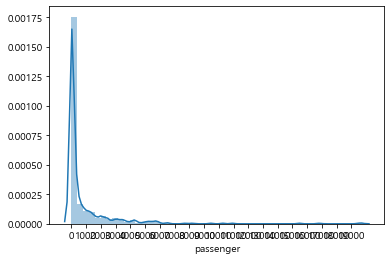

In [74]:
temp = train.groupby(['bus_route_id'])['18~20_ride'].agg([('passenger', 'sum')]).reset_index()
sns.distplot(a=temp['passenger'])
plt.xticks(ticks=np.arange(0, 20000,1000))

In [174]:
# bus_route_id 기준 18~20시 혼잡도 계산(승객 수 합) 10000, 5000, 2000, 700, 200, 50 순서로 7부터 1까지
# 대부분 1000이하에 있는데 이렇게 나누는 게 의미가 있을지는 모르겠음

def congestion():
    df = train.groupby(['bus_route_id'])['18~20_ride'].agg([('passenger', 'sum')])
    df = df.sort_values(by = 'passenger', ascending=False).reset_index()
    
    def f(x):
        if x > 10000:
            return 7
        
        elif x > 5000:
            return 6
        
        elif x > 2000:
            return 5
        
        elif x > 700:
            return 4
        
        elif x > 200:
            return 3
        
        elif x > 50:
            return 2
        
        else:
            return 1
        
    df['congestion'] = df['passenger'].apply(f)
    df = df[['bus_route_id', 'congestion']]
        
    tr = pd.merge(train, df, how='left', on='bus_route_id')
    te = pd.merge(test, df, how='left', on='bus_route_id')
      
    # 결측치는 데이터 프레임 df의 'congestion'의 중간값인 4로 대체
    te = te.fillna(4)
     
    return tr, te

In [175]:
train, test = congestion()

train.shape, test.shape

((415423, 44), (228170, 43))

In [ ]:
train['location'] = train['latitude'].astype(str) + ',' + train['longitude'].astype(str)
test['location'] = test['latitude'].astype(str) + ',' + test['longitude'].astype(str)

train.shape, test.shape

In [176]:
train['cue'] = 0
test['cue'] = 1

train.shape, test.shape

((415423, 45), (228170, 44))

## 5. 오전 탑승량 통계량 추가 (route_station으로 groupby)

In [177]:
# 트레인셋 테스트셋 concat > cue컬럼에서 서로 구분가능하게 0과 1로 구분
# (아래 피처 추가에 대한 것들이 다 시간이 오래걸려서 합쳐놓은 듯)
# 오전 시간대 탑승, 하차, 2시간으로 합친 것 탑승과 하차 모두 합과 평균에 대해 만들어줌.
# 만든 통계량에 대해 다시 한 번 더 통계량을 만드는 작업은 굳이 필요없을 듯(앙상블 모델에서 해주거나, PCA를 통해 가능)

def morning() :
    
    # merge
    data = pd.concat([train, test])
    
    a = data.groupby(['route_station'])['1012a'].agg({'sum', 'mean'}).reset_index()
    a.columns = ['route_station', '1012a_sum','1012a_mean']

    b = data.groupby(['route_station'])['1012b'].agg({'sum', 'mean'}).reset_index()
    b.columns = ['route_station', '1012b_sum','1012b_mean']
    b = b[['1012b_sum','1012b_mean']]

    c = data.groupby(['route_station'])['10~11_ride'].agg({'sum', 'mean'}).reset_index()
    c.columns = ['route_station', '10~11_ride_sum','10~11_ride_mean']
    c = c[['10~11_ride_sum','10~11_ride_mean']]

    d = data.groupby(['route_station'])['10~11_takeoff'].agg({'sum', 'mean'}).reset_index()
    d.columns = ['route_station', '10~11_takeoff_sum','10~11_takeoff_mean']
    d = d[['10~11_takeoff_sum','10~11_takeoff_mean']]

    e = data.groupby(['route_station'])['11~12_ride'].agg({'sum', 'mean'}).reset_index()
    e.columns = ['route_station', '11~12_ride_sum','11~12_ride_mean']
    e = e[['11~12_ride_sum','11~12_ride_mean']]

    f = data.groupby(['route_station'])['11~12_takeoff'].agg({'sum', 'mean'}).reset_index()
    f.columns = ['route_station', '11~12_takeoff_sum','11~12_takeoff_mean']
    f = f[['11~12_takeoff_sum','11~12_takeoff_mean']]

    g = data.groupby(['route_station'])['1820_r_mean'].agg({'sum', 'mean'}).reset_index()
    g.columns = ['route_station', '1820_r_mean_sum','1820_r_mean_mean']
    g = g[['1820_r_mean_sum','1820_r_mean_mean']]

    h = data.groupby(['route_station'])['1820_r_sum'].agg({'sum', 'mean'}).reset_index()
    h.columns = ['route_station', '1820_r_sum_sum','1820_r_sum_mean']
    h = h[['1820_r_sum_sum','1820_r_sum_mean']]

    i = data.groupby(['route_station'])['1820_rs_mean'].agg({'sum', 'mean'}).reset_index()
    i.columns = ['route_station', '1820_rs_mean_sum','1820_rs_mean_mean']
    i = i[['1820_rs_mean_sum','1820_rs_mean_mean']]

    j = data.groupby(['route_station'])['1820_rs_sum'].agg({'sum', 'mean'}).reset_index()
    j.columns = ['route_station', '1820_rs_sum_sum','1820_rs_sum_mean']
    j = j[['1820_rs_sum_sum','1820_rs_sum_mean']]

    k = data.groupby(['route_station'])['1820_s_mean'].agg({'sum', 'mean'}).reset_index()
    k.columns = ['route_station', '1820_s_mean_sum','1820_s_mean_mean']
    k = k[['1820_s_mean_sum','1820_s_mean_mean']]

    l = data.groupby(['route_station'])['1820_s_sum'].agg({'sum', 'mean'}).reset_index()
    l.columns = ['route_station', '1820_s_sum_sum','1820_s_sum_mean']
    l = l[['1820_s_sum_sum','1820_s_sum_mean']]

    m = data.groupby(['route_station'])['1820_w_mean'].agg({'sum', 'mean'}).reset_index()
    m.columns = ['route_station', '1820_w_mean_sum','1820_w_mean_mean']
    m = m[['1820_w_mean_sum','1820_w_mean_mean']]

    n = data.groupby(['route_station'])['1820_w_sum'].agg({'sum', 'mean'}).reset_index()
    n.columns = ['route_station', '1820_w_sum_sum','1820_w_sum_mean']
    n = n[['1820_w_sum_sum','1820_w_sum_mean']]

    o = data.groupby(['route_station'])['68a'].agg({'sum', 'mean'}).reset_index()
    o.columns = ['route_station', '68a_sum','68a_mean']
    o = o[['68a_sum','68a_mean']]

    p = data.groupby(['route_station'])['68b'].agg({'sum', 'mean'}).reset_index()
    p.columns = ['route_station', '68b_sum','68b_mean']
    p = p[['68b_sum','68b_mean']]

    q = data.groupby(['route_station'])['6~7_ride'].agg({'sum', 'mean'}).reset_index()
    q.columns = ['route_station', '6~7_ride_sum','6~7_ride_mean']
    q = q[['6~7_ride_sum','6~7_ride_mean']]

    r = data.groupby(['route_station'])['6~7_takeoff'].agg({'sum', 'mean'}).reset_index()
    r.columns = ['route_station', '6~7_takeoff_sum','6~7_takeoff_mean']
    r = r[['6~7_takeoff_sum','6~7_takeoff_mean']]

    s = data.groupby(['route_station'])['7~8_ride'].agg({'sum', 'mean'}).reset_index()
    s.columns = ['route_station', '7~8_ride_sum','7~8_ride_mean']
    s = s[['7~8_ride_sum','7~8_ride_mean']]

    t = data.groupby(['route_station'])['7~8_takeoff'].agg({'sum', 'mean'}).reset_index()
    t.columns = ['route_station', '7~8_takeoff_sum','7~8_takeoff_mean']
    t = t[['7~8_takeoff_sum','7~8_takeoff_mean']]

    u = data.groupby(['route_station'])['810a'].agg({'sum', 'mean'}).reset_index()
    u.columns = ['route_station', '810a_sum','810a_mean']
    u = u[['810a_sum','810a_mean']]

    v = data.groupby(['route_station'])['810b'].agg({'sum', 'mean'}).reset_index()
    v.columns = ['route_station', '810b_sum','810b_mean']
    v = v[['810b_sum','810b_mean']]

    w = data.groupby(['route_station'])['8~9_ride'].agg({'sum', 'mean'}).reset_index()
    w.columns = ['route_station', '8~9_ride_sum','8~9_ride_mean']
    w = w[['8~9_ride_sum','8~9_ride_mean']]

    x = data.groupby(['route_station'])['8~9_takeoff'].agg({'sum', 'mean'}).reset_index()
    x.columns = ['route_station', '8~9_takeoff_sum','8~9_takeoff_mean']
    x = x[['8~9_takeoff_sum','8~9_takeoff_mean']]

    y = data.groupby(['route_station'])['9~10_ride'].agg({'sum', 'mean'}).reset_index()
    y.columns = ['route_station', '9~10_ride_sum','9~10_ride_mean']
    y = y[['9~10_ride_sum','9~10_ride_mean']]

    z = data.groupby(['route_station'])['9~10_takeoff'].agg({'sum', 'mean'}).reset_index()
    z.columns = ['route_station', '9~10_takeoff_sum','9~10_takeoff_mean']
    z = z[['9~10_takeoff_sum','9~10_takeoff_mean']]
    
    df = pd.concat([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z],axis=1)
    df = pd.merge(data, df, how='left', on='route_station')
    
    return df

In [178]:
data = morning()

data.shape

(643593, 97)

## 6. 배차간격 추가
-  bts 데이터 이용 (굳이 이렇게 오래걸려서 안 하고 제주도 배차간격 시간 검색해서 bus id, route_id, 요일별로 넣어줘도 괜찮을 듯)

1. 탑승날짜, 탑승시간, 탑승 정류소 코드, 버스 번호로 그룹바이한 후 user_count컬럼에 대해 합해서 탑승객 수로 만들고 정렬 (새로운 데이터프레임에)
2. 1에서 정리한 것을 바탕으로 로우별로 t로우와 t+1로우에서 탑승 날짜, 탑승 정류소, 탑승 버스 번호가 같은 경우에만 배차간격 구해줌(시간 차이)
3. 이후 시간에 대한 컬럼을 초랑 분단위로 조정해가면서 최종적으로 bus_route_id 별로 평균값 내줌(이때 간격이 3분 미만이거나 3시간 초과인 경우 제외)

(na값이 있는 것들은 대부분탑승인원이 거의 없는 것들이라서 9999로 채움)


In [180]:
train['bus_route_id'] = train['bus_route_id'].astype(np.int64)
test['bus_route_id'] = test['bus_route_id'].astype(np.int64)

In [181]:
bts['geton_time2'] = pd.to_datetime(bts['geton_time'])

f = bts.groupby(['geton_date', 'geton_time2', 'geton_station_code', 'bus_route_id'])['user_count'].agg([('탑승객_수', 'sum')]).reset_index().sort_values(by=['geton_date','geton_station_code','bus_route_id','geton_time2'], ascending=True).reset_index()

f['index'] = list(range(0, len(f)))

In [184]:
time = []

for i in range(0, len(f)-1):
    
    if ((f.iloc[i].geton_date == f.iloc[i+1].geton_date) & (f.iloc[i].geton_station_code == f.iloc[i+1].geton_station_code) & (f.iloc[i].bus_route_id == f.iloc[i+1].bus_route_id)):
        
        time.append(f.iloc[i+1].geton_time2 - f.iloc[i].geton_time2)
        
    else:
        time.append(0)
        
time.insert(0, '0')

In [186]:
def get_sec(time_str):

    h, m, s = time_str.split(':')

    return int(h) * 3600 + int(m) * 60 + int(s)

In [189]:
def bus_interval():
    
    f['time']=time # 전체 날짜+시간
    f['time2']=f['time'].astype(str).str[7:] # 시/분/초
    
    interval = f.copy()
    interval['time2'] = interval['time2'].astype(str).replace('', '00:00:00')
    interval['bus_route_id']=interval['bus_route_id'].astype(object)
    
    time4 = []
    
    for i in interval['time2']:
        time4.append(get_sec(i))
        
    interval['time4'] = time4
    interval['time4'] = (interval['time4'] / 60).astype(int) # 분단위로 단위 조정
    
    interval = interval[interval['time4'] > 3] # 배차간격이 3분 이하인 것 제외
    interval = interval[interval['time4'] < 180] # 배차간격이 3시간 이상인 것 제외
    
    interval = interval.groupby('bus_route_id')['time4'].agg([('bus_interval', 'mean')]).reset_index()
    # bus_route_id별로 분단위 배차간격을 평균해서 'bus_interval'이라는 컬럼으로 생성
    
    interval['bus_interval'] = interval['bus_interval'].astype(int)
    
    # 시간절약을 위해 csv로 저장
    interval.to_csv('bus_interval_final.csv', index=False)
    
    print('success.. !')

In [190]:
bus_interval()

success.. !


In [191]:
bus_interval = pd.read_csv('bus_interval_final.csv')

In [193]:
data['bus_route_id'] = data['bus_route_id'].astype(np.int64)
# 위에서 object로 만들어줘서 다시 integer로 변경

In [194]:
data = pd.merge(data, bus_interval, how='left', on='bus_route_id')

In [195]:
data['bus_interval'] = data['bus_interval'].fillna(9999)

## 7. Label Encoding

In [197]:
labelencoder = LabelEncoder()
df_encode = data[['bus_route_id', 'station_code', 'route_station_weekday', 'route_station']]
df_encoded = df_encode.apply(labelencoder.fit_transform)

data['bus_route_id2']=df_encoded['bus_route_id']
data['station_code2']=df_encoded['station_code']
data['route_station_weekday2']=df_encoded['route_station_weekday']
data['route_station2']=df_encoded['route_station']

data.shape

(643593, 103)

## 8. 날씨

In [198]:
def weather() :

    weather_data = pd.read_csv('weather.csv', encoding = 'utf-8')
    weather_data['id'] = range(0,46)

    a = pd.DataFrame(data.date.unique(), columns=['date']) ; a['id'] = range(0,46)
    weather_data = pd.merge(a, weather_data)
    weather_data = weather_data[['date','현재일기_10','체감온도_10','일강수_10']]
    weather_data = weather_data.replace(' ', 0)
    df = pd.merge(data, weather_data, on='date')
    # label_encoder
    labelencoder = LabelEncoder()
    df_encode = df[['현재일기_10']]
    df_encoded = df_encode.apply(labelencoder.fit_transform)
    df['현재일기_10']=df_encoded['현재일기_10']
    # object > float 변수변환
    df['현재일기_10'] = df['현재일기_10'].astype(float)
    df['체감온도_10'] = df['체감온도_10'].astype(float)
    df['일강수_10'] = df['일강수_10'].astype(float)
    return df

In [199]:
data = weather()

data.shape

(643593, 106)

## 9. 기타 변수처리 1

In [200]:
# 1. 요일 더미변수로

data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.weekday
data = pd.get_dummies(data,columns=['weekday'])
data['weekday'] = data['date'].dt.weekday
data.shape

(643593, 113)

In [201]:
# 2. 시내외 구분 더미변수로

data['in_out'].value_counts()
data['in_out'] = data['in_out'].map({'시내':0,'시외':1})

data.shape

(643593, 113)

## 10. 좌표데이터 활용 변수
- 시간이 오래 걸림(qgis 같은 걸로 한 번 거칠 수 있다면 그게 더 좋을 수 있을 듯)

    1. 제주시로부터의 거리
    2. 제주시청 / 공항 / 한라병원 / 제주도청신제주로터리 / 제주중앙여고 / 동문시장 / 제주고등학교 / 중앙로 / 노형오거리 / 제주지방법원으로부터 거리

In [202]:
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
data['dis_jejusi'] = [geopy.distance.vincenty((data['latitude'].iloc[i], data['longitude'].iloc[i]), coords_jejusi). km for i in range(len(data))]

coords_jejusicheong1 = (33.49892, 126.53035) #제주시청(광양방면)의 위도 경도
coords_jejuairport = (33.50661, 126.49345) #제주국제공항(구제주방면)의 위도 경도
coords_hallahosp = (33.48963, 126.486) #한라병원의 위도 경도
coords_rotary = (33.49143, 126.49678) # 제주도청신제주로터리의 위도 경도
coords_jejucenterhigh = (33.48902, 126.5392) #제주중앙여자고등학교의 위도 경도
coords_jejumarket = (33.51315, 126.52706) #동문시장의 위도 경도
coords_jejusclass = (33.47626, 126.48141) #제주고등학교/중흥S클래스의 위도 경도
coords_centerroad = (33.51073, 126.5239) #중앙로(국민은행)의 위도 경도
coords_fiveway = (33.48667, 126.48092) # 노형오거리의 위도 경도
coords_law = (33.49363, 126.53476) # 제주지방법원(광양방면)의 위도 경도

data['dis_jejusicheong1'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_jejusicheong1).km for i in range(len(data))]
data['dis_jejuairport'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_jejuairport).km for i in range(len(data))]
data['dis_hallahosp'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_hallahosp).km for i in range(len(data))]
data['dis_rotary'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_rotary).km for i in range(len(data))]
data['dis_jejucenterhigh'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_jejucenterhigh).km for i in range(len(data))]
data['dis_jejumarket'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_jejumarket).km for i in range(len(data))]
data['dis_jejusclass'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_jejusclass).km for i in range(len(data))]
data['dis_centerroad'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_centerroad).km for i in range(len(data))]
data['dis_fiveway'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_fiveway).km for i in range(len(data))]
data['dis_law'] = [geopy.distance.vincenty((data['latitude'].iloc[i],data['longitude'].iloc[i]), coords_law).km for i in range(len(data))]

data.shape

(643593, 124)

In [203]:
data.to_csv('distnace_data.csv')

## 11. 총 승객 수
1. 출근 시간 총 승객 수
2. 일자별 시간대 총 승객 수(6 ~ 7시, 7 ~ 8시, 8 ~ 9시, 9 ~ 10시, 10 ~ 11시)

In [204]:
# 출근 시간 총 승객 수

data['ride_sum'] = data['6~7_ride'] + data['7~8_ride'] + data['8~9_ride'] + data['9~10_ride'] + data['10~11_ride'] + data['11~12_ride'] 
data['takeoff_sum'] = data['6~7_takeoff'] + data['7~8_takeoff'] + data['8~9_takeoff'] + data['9~10_takeoff'] + data['10~11_takeoff'] + data['11~12_takeoff'] 

data.shape

(643593, 126)

In [205]:
# 일자별 시간대 총 승객 수

f = data.groupby('date')['6~7_ride'].agg([('6~7_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['7~8_ride'].agg([('7~8_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['8~9_ride'].agg([('8~9_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['9~10_ride'].agg([('9~10_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['10~11_ride'].agg([('10~11_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

data.shape

(643593, 131)

## 12. 기타 변수처리2
1. 주말 주중 분리
2. 연휴 변수 추가
3. 18~20시 요일별 평균 승객수 변수 추가
4. 시내외 평균 승객수 추가

In [206]:
# 주말과 주중 분리

def h(x):
    if x ==5:
        return 1
    elif x==6:
        return 1
    else:
        return 0
    
data['weekend'] = data['weekday'].apply(h)

data.shape

(643593, 131)

In [207]:
# 연휴 변수 추가

def g(x):
    if x in ['2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09']:
        return 1
    else:
        return 0
    
data['holiday'] = data['date'].apply(g) 

data.shape

(643593, 132)

In [209]:
# 18~20시 요일별 평균 승객 수 변수 추가

def week_mean():
    
    df = data.reset_index(drop=True)
    # df.groupby('weekday')['18~20_ride'].mean()
    df['weekdaymean'] = 1
    
    index0 = df.query('weekday==0').index
    index1 = df.query('weekday==1').index
    index2 = df.query('weekday==2').index
    index3 = df.query('weekday==3').index
    index4 = df.query('weekday==4').index
    index5 = df.query('weekday==5').index
    index6 = df.query('weekday==6').index
    
    df.iloc[index0,-1] = 1.343710
    df.iloc[index1,-1] = 1.375319
    df.iloc[index2,-1] = 1.430856
    df.iloc[index3,-1] = 1.256710
    df.iloc[index4,-1] = 1.067439
    df.iloc[index5,-1] = 1.062123
    df.iloc[index6,-1] = 1.034282
    
    return df

In [210]:
data = week_mean()

data.shape

(643593, 133)

In [211]:
# 시내외 평균 승객 수 추가

data['in_out_mean'] = 1
inindex = data.query('in_out == "시내"').index
outindex = data.query('in_out == "시외"').index

data.iloc[inindex, -1] = 1.228499
data.iloc[outindex, -1] = 2.044345
data['congestion'] = data['congestion'].astype('int64')

data.shape

(643593, 134)

## 13. BTS데이터 승객 카테고리 관련 변수 추가
1. bts 데이터에서 승객별 구분한 것을 bus_route_id 별로 합쳐서 성인, 유아, 10대, 노인만 추가함 (굳이 필요있을지 모르겠음)
2. bts 데이터에서 승객 카테고리의 비율을 추가(얘는 의미있을 듯)

In [212]:
# bus_route_id 별로 승객 구분의 탑승 합을 구함

def category_people():
    bts['bus_route_id'] = bts['bus_route_id'].astype(str)
    
    f = bts.groupby(['bus_route_id', 'user_category'])['user_count'].agg([('승객수', 'sum')]).reset_index()
    
    g = pd.pivot_table(f, values='승객수', index='bus_route_id', columns='user_category', fill_value=0).reset_index()
    g.columns = ['bus_route_id', 'adult','kids','teen','elder','jang','jang2','ugong','ugong2']
    g = g[['bus_route_id', 'adult','kids','teen','elder']]
    
    # merge
    df = pd.merge(data, g, how='left', on='bus_route_id')
    
    # 결측값을 평균값으로 처리
    df['adult'] = df['adult'].fillna(2363.077778)
    df['kids'] = df['kids'].fillna(60.426984)
    df['teen'] = df['teen'].fillna(448.277778)
    df['elder'] = df['elder'].fillna(751.309524)
    
    return df

In [213]:
data['bus_route_id'] = data['bus_route_id'].astype(str)

In [214]:
data = category_people()

data.shape

(643593, 138)

In [215]:
# 승객 카테고리별 비율 추가

def category_people_ratio():
    
    a = bts.groupby('bus_route_id')['user_count'].agg([('전체', 'sum')]).reset_index()
    b = bts.groupby(['bus_route_id', 'user_category'])['user_count'].agg([('승객수', 'sum')]).reset_index()
    # 비율을 만들기 위해 버스 번호별로 승객 수 합 넣고, 버스 번호 & 승객 카테고리별로 승객 수 합 또 넣음
    
    c = pd.merge(b, a, on='bus_route_id')
    c['비율'] = c['승객수']/c['전체']
    c = pd.pivot_table(c, values='비율', index='bus_route_id', columns='user_category', fill_value=0).reset_index()
    c.columns = ['bus_route_id', 'adult_prop','kids_prop','teen_prop','elder_prop','jang_prop','jang2_prop','ugong_prop','ugong2_prop']
    f = c[['bus_route_id', 'adult_prop','kids_prop','teen_prop','elder_prop']]
    
    df = pd.merge(data, f, how='left', on='bus_route_id')
    
    # 결측값을 평균으로 처리
    df['adult_prop'] = df['adult_prop'].fillna(0.549702)
    df['kids_prop'] = df['kids_prop'].fillna(60.426984)
    df['teen_prop'] = df['teen_prop'].fillna(0.019902)
    df['elder_prop'] = df['elder_prop'].fillna(0.235848)

    return df

In [216]:
data = category_people_ratio()

data.shape

(643593, 142)

In [217]:
data.to_csv('before_finance.csv')

## 14. 금융데이터 관련 변수 추가
- 지오코딩(네이버 이용하면 될 듯) > 여기서 시단위랑 동단위를 가져옴
- 원본 데이터와 제주 금융 데이터의 위경도를 지오코딩해서 시, 동단위로 만들고 동단위로 아래와 같이 그룹바이

    1. 읍면동별 직업군 수
    2. 읍면동별 평균소득액
    3. 읍면동별 평균소비액
    
   
- 위 3가지를 평균값, 합산값, 전체 중 비율 컬럼으로 만들어서 추가
- (na값은 각 컬럼의 평균값으로)

In [2]:
data = pd.read_csv('before_finance.csv')

In [7]:
def change(x):
    return str(x)[0:9]

In [8]:
data['longitude'] = data['longitude'].apply(change)
data['latitude'] = data['latitude'].apply(change)
data['location'] = data['latitude'] + ',' + data['longitude']

In [11]:
def jeoju_love():
    
    loc_data = pd.read_csv('data_address.csv', encoding='cp949')
    loc_life = pd.read_csv('life_address.csv', encoding='cp949')
    
    loc_data = loc_data[['location', 'dong', 'si']]
    loc_life = loc_life[['location', 'dong', 'si']]
    
    df = pd.merge(data, loc_data, how='left', on='location')
    
    jeju_life = pd.read_csv('jeju_financial_life_data.csv')
    jeju_life['x_axis'] = jeju_life['x_axis'].apply(change)
    jeju_life['y_axis'] = jeju_life['y_axis'].apply(change)
    jeju_life['location'] = jeju_life['x_axis'] + ',' + jeju_life['y_axis']
    jeju_life2 = pd.merge(jeju_life, loc_life, how='left', on='location')
    
    dong_f1 = jeju_life2.groupby(['dong'])[['job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self','vehicle_own_rat', 'avg_income', 'med_income', 'avg_spend']].mean().reset_index()
    dong_f1.columns = ['dong','mean_job_majorc', 'mean_job_smallc', 'mean_job_public', 'mean_job_profession', 'mean_job_self','mean_vehicle_own_rat', 'mean_avg_income', 'mean_med_income', 'mean_avg_spend']
    
    dong_f2 = jeju_life2.groupby(['dong'])[['job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self','vehicle_own_rat', 'avg_income', 'med_income', 'avg_spend']].sum().reset_index()
    dong_f2.columns=['dong','sum_job_majorc', 'sum_job_smallc', 'sum_job_public', 'sum_job_profession', 'sum_job_self','sum_vehicle_own_rat', 'sum_avg_income', 'sum_med_income', 'sum_avg_spend']

    dong_f3 = (jeju_life2.groupby(['dong'])['job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self','vehicle_own_rat', 'avg_income', 'med_income', 'avg_spend'].sum()/jeju_life2.groupby(['dong'])['job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self','vehicle_own_rat', 'avg_income', 'med_income', 'avg_spend'].sum().sum()).reset_index()
    dong_f3.columns = ['dong','rate_job_majorc', 'rate_job_smallc', 'rate_job_public', 'rate_job_profession', 'rate_job_self','rate_vehicle_own_rat', 'rate_avg_income', 'rate_med_income', 'rate_avg_spend']   
    # 평균과 전체합을 구해 비율을 산정해주는 작업
    
    m_1 = pd.merge(dong_f1, dong_f2, how='left', on='dong')
    m_2 = pd.merge(m_1, dong_f3, how='left', on='dong')
    df = pd.merge(df, m_2, how='left', on='dong')
    
    # 결측값 채우기
    df['mean_job_majorc'] = df['mean_job_majorc'].fillna(0.024219)
    df['mean_job_smallc'] = df['mean_job_smallc'].fillna(0.145757)
    df['mean_job_public'] = df['mean_job_public'].fillna(0.032768)
    df['mean_job_profession'] = df['mean_job_profession'].fillna(0.014855)
    df['mean_job_self'] = df['mean_job_self'].fillna(0.222090)
    df['mean_vehicle_own_rat'] = df['mean_vehicle_own_rat'].fillna(0.041161)
    df['mean_avg_income'] = df['mean_avg_income'].fillna(34221420)
    df['mean_med_income'] = df['mean_med_income'].fillna(30645290)
    df['mean_avg_spend'] = df['mean_avg_spend'].fillna(4224923)

    df['sum_job_majorc'] = df['sum_job_majorc'].fillna(3.717861e+00)
    df['sum_job_smallc'] = df['sum_job_smallc'].fillna(2.078142e+01)
    df['sum_job_public'] = df['sum_job_public'].fillna(4.747755e+00)
    df['sum_job_profession'] = df['sum_job_profession'].fillna(2.169554e+00)
    df['sum_job_self'] = df['sum_job_self'].fillna(3.044199e+01)
    df['sum_vehicle_own_rat'] = df['sum_vehicle_own_rat'].fillna(5.609080e+00)
    df['sum_avg_income'] = df['sum_avg_income'].fillna(4.998226e+09)
    df['sum_med_income'] = df['sum_med_income'].fillna(4.455924e+09)
    df['sum_avg_spend'] = df['sum_avg_spend'].fillna(6.147678e+08)

    df['rate_job_majorc'] = df['rate_job_majorc'].fillna(1.388889e-02)
    df['rate_job_smallc'] = df['rate_job_smallc'].fillna(1.388889e-02)
    df['rate_job_public'] = df['rate_job_public'].fillna(1.388889e-02)
    df['rate_job_profession'] = df['rate_job_profession'].fillna(1.388889e-02)
    df['rate_job_self'] = df['rate_job_self'].fillna(1.388889e-02)
    df['rate_vehicle_own_rat'] = df['rate_vehicle_own_rat'].fillna(1.388889e-02)
    df['rate_avg_income'] = df['rate_avg_income'].fillna(1.388889e-02)
    df['rate_med_income'] = df['rate_med_income'].fillna(1.388889e-02)
    df['rate_avg_spend'] = df['rate_avg_spend'].fillna(1.388889e-02)

    return df

In [12]:
data = jeoju_love()

data.shape

(643593, 173)

In [17]:
# 요 위에서 'Unnamed: 0'이라는 컬럼 제거했는데 해당 셀 삭제했음 > 이 컬럼은 dataframe 저장시 index=False 안 해줘서 생긴 것
data.to_csv('after_finance.csv', encoding='cp949', index=False)

## 15. 기타 변수처리3

1. 수요가 많을 것으로 예상되는 '대학교', '고등학교', '환승', '공항', '터미널' 이름이 들어간 데이터 구분(더미)
2. 동별 라벨인코딩
3. 날씨 측정소와 각 지점까지의 거리 계산
4. 강수량 추가
5. 비오는날과 안 오는날 더미변수로 생성
6. 승하차 시간대 통합변수 t~t3 시간대로 (탑승 하차 모두)

In [18]:
# 고등학교, 대학교 더미 만들기

g = data[data['station_name'].str.contains('고등학교')]
highschool = list(g['station_name'].unique())

g = data[data['station_name'].str.contains('대학교')]
university = list(g['station_name'].unique())

In [19]:
def f(x):
    if x in highschool:
        return 1
    elif x in university:
        return 1
    else:
        return 0

In [20]:
data['school'] = data['station_name'].apply(f) 

In [21]:
# 주요 교통 node 더미 만들기

g = data[data['station_name'].str.contains('환승')]
transfer = list(g['station_name'].unique())

g = data[data['station_name'].str.contains('공항')]
airport = list(g['station_name'].unique())

g = data[data['station_name'].str.contains('터미널')]
terminal = list(g['station_name'].unique())

In [22]:
terminal = list(g['station_name'].unique())
def f(x):
    if x in transfer:
        return 1
    elif x in airport:
        return 1
    elif x in terminal:
        return 1
    else:
        return 0

In [23]:
data['transfer'] = data['station_name'].apply(f) 

data.shape

(643593, 174)

In [24]:
# 동-라벨인코딩
labelencoder = LabelEncoder()
df_encode = data[['dong']]
df_encoded = df_encode.apply(labelencoder.fit_transform)

data['dong2'] = df_encoded['dong']

data.shape

(643593, 175)

In [25]:
# 기상 측정소와 정류장 사이 거리 계산

def dist() :
    jeju=(33.51411, 126.52969) # 제주 측정소 근처
    gosan=(33.29382, 126.16283) #고산 측정소 근처
    seongsan=(33.38677, 126.8802) #성산 측정소 근처
    po=(33.24616, 126.5653) #서귀포 측정소 근처

    t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
    t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
    t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
    t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]

    data['dis_jeju'] = t1
    data['dis_gosan']=t2
    data['dis_seongsan']=t3
    data['dis_po']=t4

    total = pd.DataFrame(list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
    data['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
    
    return data

In [26]:
data = dist()

data.shape

(643593, 180)

In [ ]:
## 일단 날씨 생략(강수량, 비오는날 더미변수)

In [27]:
# 승하차 시간대를 3시간 단위로 통합(t~t+3)
data['69a'] = data['6~7_ride']+data['7~8_ride']+data['8~9_ride']
data['912a']=data['9~10_ride']+data['10~11_ride']+data['11~12_ride']

data['69b'] = data['6~7_takeoff']+data['7~8_takeoff']+data['8~9_takeoff']
data['912b'] = data['9~10_takeoff']+data['10~11_takeoff']+data['11~12_takeoff']

data.shape

(643593, 184)

In [28]:
data.to_csv('without_weather.csv', encoding='cp949', index=False)